### Notebook to investigate similarity (rot-invariance) on each layer

In [2]:
%matplotlib inline
import os
import cv2
import gc
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.data import parallel_interleave

In [24]:
from tensorflow.python.keras.models import Model

In [30]:
import math
import pickle
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity 

In [3]:
def data_extractor_resize_fn(filelist,prefetch=1,height=32,width=32,channel=6,read_threads=4, distribute=(1, 0)):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        # conversion of tensor
        patch = tf.cast(patch, tf.float32)
        patch = tf.image.resize_images(patch, (height, width))
        return patch
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patches_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch = sess.run(next_element)
                patches_list.append(patch)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patches_list

In [4]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

#### Load dataset

In [5]:
tf_datadir = "/project2/foster/clouds/data/clouds_laads_multiprocessed_2000_2018_band28_29_31_circle_2"
filelist = glob.glob(os.path.join(tf_datadir, '2-10*.tfrecord'))

In [6]:
## load 
nfiles = 1
fdx = np.random.randint(0,len(filelist),nfiles)
patches_list = []
for ifile in [filelist[i] for i in fdx]:
    patches_list.append(data_extractor_resize_fn([ifile],height=32,width=32,channel=6 ))
print("NORMAL END")

## get patch
height = width = 32
channel = 6
patches = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,height,width, channel) for i in patches_list[0]],
    axis=0)
print(patches.shape)

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process
NORMAL END
(2000, 32, 32, 6)


#### Load Encoder and Decoder

In [7]:
# 67011582; Best model
model_datadir = '/home/tkurihana/rotate_invariant/stepbystep/transform/output_model'
expname = 67011582
model_dir = os.path.join(model_datadir,str(expname) )
encoder = load_latest_model(model_dir, mtype='encoder')
decoder = load_latest_model(model_dir, mtype='decoder')

 Load encoder at 100 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
 Load decoder at 100 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Check layer names
layer_names = [layer.name for layer in encoder.layers]

In [9]:
layer_names

['encoding_input',
 'conv2d',
 'leaky_re_lu',
 'conv2d_1',
 'leaky_re_lu_1',
 'conv2d_2',
 'leaky_re_lu_2',
 'conv2d_3',
 'batch_normalization',
 'leaky_re_lu_3',
 'conv2d_4',
 'leaky_re_lu_4',
 'conv2d_5',
 'leaky_re_lu_5',
 'conv2d_6',
 'batch_normalization_1',
 'leaky_re_lu_6',
 'conv2d_7',
 'leaky_re_lu_7',
 'conv2d_8',
 'leaky_re_lu_8',
 'conv2d_9',
 'batch_normalization_2',
 'leaky_re_lu_9',
 'conv2d_10',
 'leaky_re_lu_10',
 'conv2d_11',
 'leaky_re_lu_11',
 'conv2d_12',
 'batch_normalization_3',
 'leaky_re_lu_12',
 'conv2d_13',
 'leaky_re_lu_13',
 'conv2d_14',
 'leaky_re_lu_14']

In [10]:
layer_name = encoder.get_layer('leaky_re_lu_14')

#### Select patches for less memory

In [13]:
spatches = patches[:100]
spatches.shape

(100, 32, 32, 6)

#### Copy and Rotate

In [15]:
def rotate_fn(images, angles):
    """
    images : 4d tensor [batch, height, width channel]
      original oprion - nearest. Additional: biilnear
    """
    rotated_tensor_images = tf.contrib.image.transform(
      images,
      tf.contrib.image.angles_to_projective_transforms(
        angles, tf.cast(tf.shape(images)[1], tf.float32), 
            tf.cast(tf.shape(images)[2], tf.float32)
        ),
    )
     #interpolation='BILINEAR'
    return rotated_tensor_images

In [16]:
def copy_rot_fn(patches, height=None, width=None, ch=None, copy_size=None):
    img_list = []
    for patch in patches:
        img_list.extend([np.reshape(patch, (1,height,width,ch))])
        img_list.extend([ np.expand_dims(np.copy(patch.reshape(height,width,ch)), axis=0) 
                     for i in range(copy_size-1)])
    imgs = np.concatenate(img_list, axis=0)
    print(imgs.shape)
    
    radians = []
    for j in range(patches.shape[0]):
        radians.extend([i*math.pi/180 for i in np.linspace(0,360,copy_size+1) ][:-1] )
    print(len(radians))
    rimgs_tf = rotate_fn(imgs, angles=radians)
    rtest_imgs = tf.keras.backend.eval(rimgs_tf)
    del imgs, rimgs_tf
    return rtest_imgs


In [17]:
#### CONFIG ####
_, h,w,c, = spatches.shape
copy_size = 12

In [20]:
rpatches = copy_rot_fn(spatches, height=h, width=w, ch=c, copy_size=copy_size)
rpatches.shape

(1200, 32, 32, 6)
1200


(1200, 32, 32, 6)

### Investigate "Invariance" layers

#### Get layers from decoder where rotation invariant is acheived 

In [27]:
decoder_results = {}
model = decoder

### processing ###
layer_names = [layer.name for layer in model.layers]
encs = encoder.predict(rpatches)
for layer_name in layer_names[1:]:
    tmp = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
    decoder_results[layer_name] = tmp.predict(encs)

In [29]:
### Check layer sizes
for ikey in decoder_results.keys():
    print(decoder_results[ikey].shape)

(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 6)
(1200, 32, 32, 6)


In [31]:
#https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict
with open('decoder_results_100.pkl', 'wb') as handle:
    pickle.dump(decoder_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Get layers from Encoder:  To check cosine similarity 

In [65]:
encoder_results = {}
model = encoder

### processing ###
layer_names = [layer.name for layer in model.layers]
#encs = encoder.predict(rpatches)
for layer_name in layer_names[1:]:
    tmp = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
    encoder_results[layer_name] = tmp.predict(rpatches)

In [66]:
### Check layer sizes
for ikey in encoder_results.keys():
    print(encoder_results[ikey].shape)

(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)


In [57]:
with open('encoder_results_100.pkl', 'wb') as handle:
    pickle.dump(encoder_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load computed cosine similarity results

In [32]:
with open('./decoder_cossim_results_100.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [36]:
# TODO: debug 99 --> 100 since we stored 100 files
a = [results[i] for i in results.keys()]
for i in a:
    print(len(i))

99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99


In [38]:
len(a[0][0])

12

In [43]:
np.asarray(a[0]).shape

(99, 12)

In [42]:
np.mean(a[0], axis=0).shape

(12,)

In [67]:
with open('./encoder_cossim_results_100.pkl', 'rb') as handle:
    encoder_cos_results = pickle.load(handle)

##### Compute average over degree for each layer

In [44]:
def comp_means(results, ikey=None):
    result = results[ikey] # (npatches, ncopues)
    deg_mean = np.mean(result, axis=0)
    return deg_mean

In [46]:
# TODO: debug 99 --> 100 since we stored 100 files
deg_mean_list = {}
for ikey in results.keys():
    deg_mean_list[ikey] =  comp_means(results, ikey=ikey)

In [70]:
results.keys()

dict_keys(['conv2d_transpose', 'leaky_re_lu_15', 'conv2d_15', 'leaky_re_lu_16', 'conv2d_16', 'batch_normalization_4', 'leaky_re_lu_17', 'conv2d_transpose_1', 'leaky_re_lu_18', 'conv2d_17', 'leaky_re_lu_19', 'conv2d_18', 'batch_normalization_5', 'leaky_re_lu_20', 'conv2d_transpose_2', 'leaky_re_lu_21', 'conv2d_19', 'leaky_re_lu_22', 'conv2d_20', 'batch_normalization_6', 'leaky_re_lu_23', 'conv2d_transpose_3', 'leaky_re_lu_24', 'conv2d_21', 'leaky_re_lu_25', 'conv2d_22', 'batch_normalization_7', 'leaky_re_lu_26', 'conv2d_23', 'leaky_re_lu_27'])

- Decoder

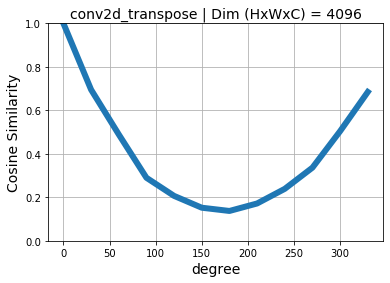

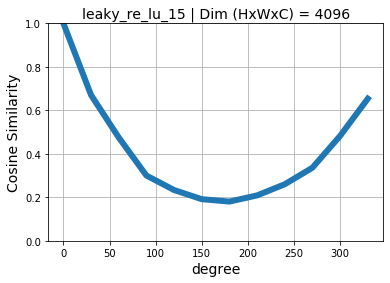

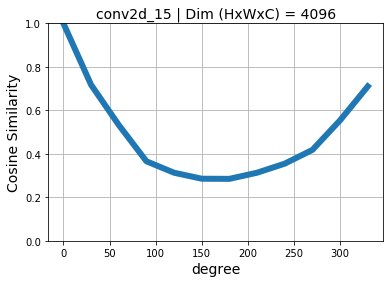

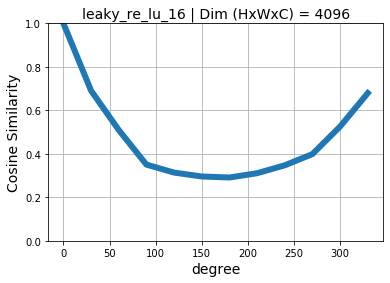

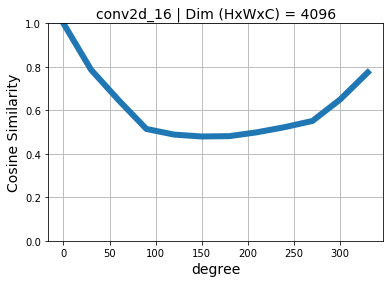

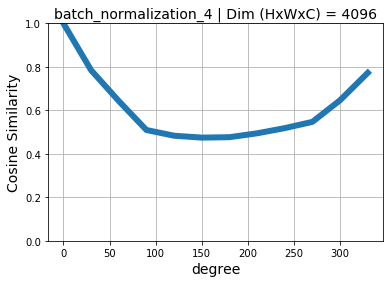

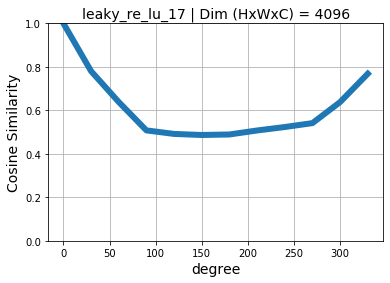

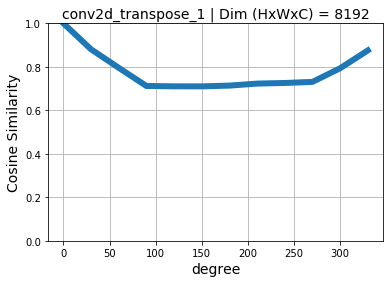

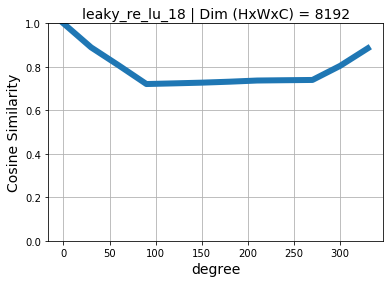

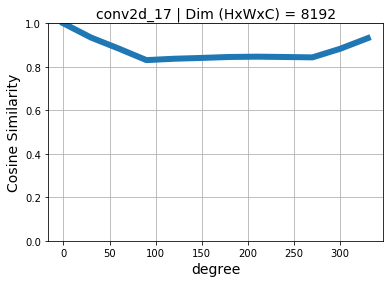

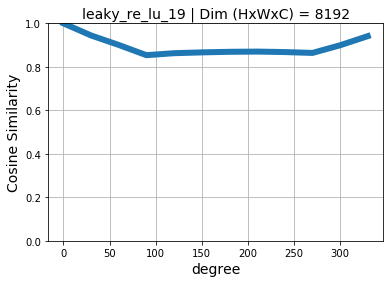

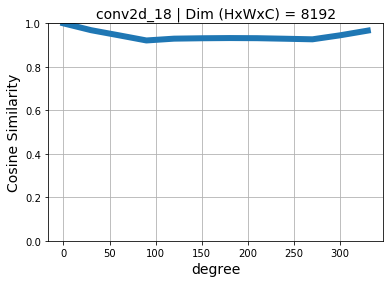

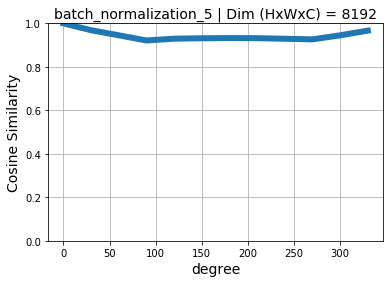

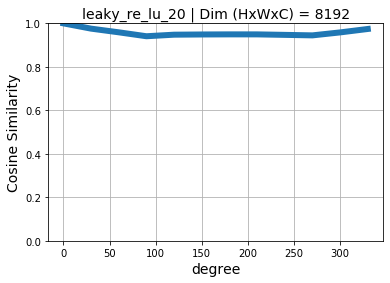

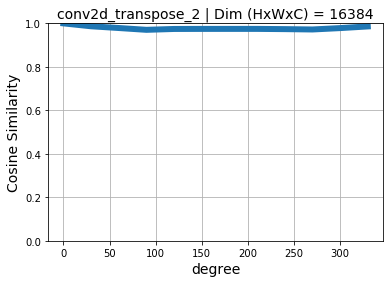

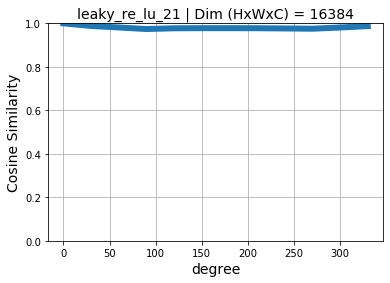

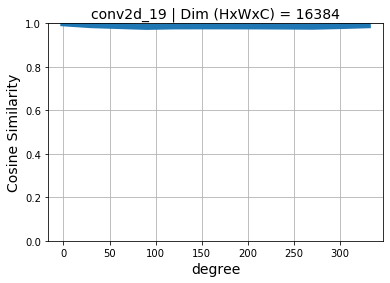

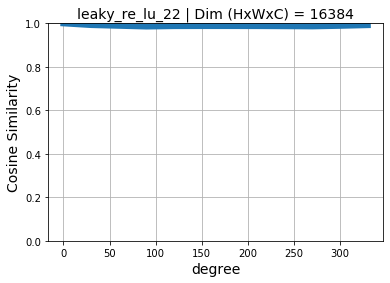

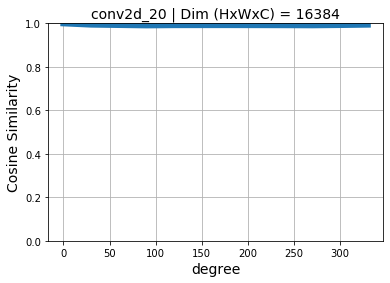

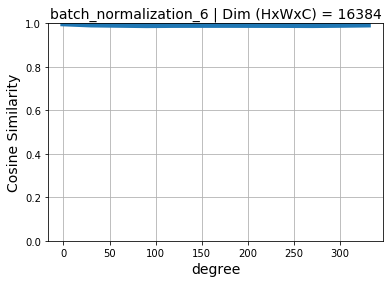

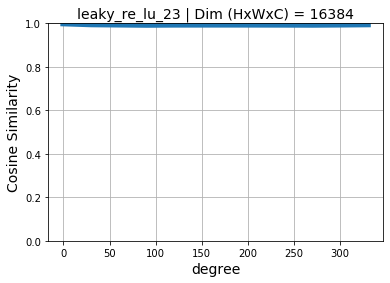

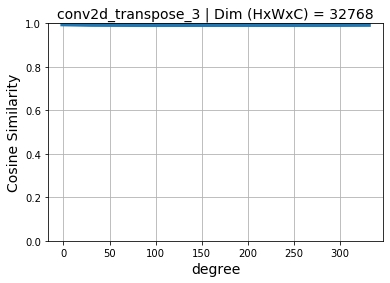

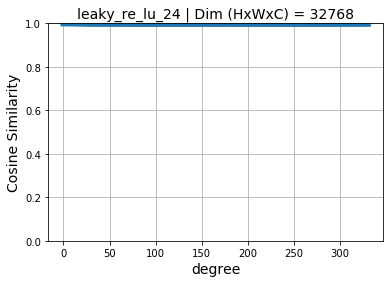

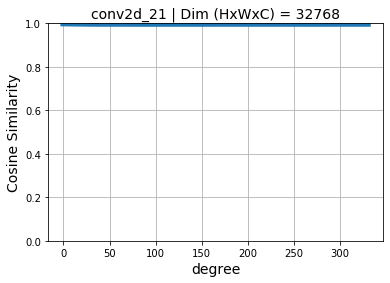

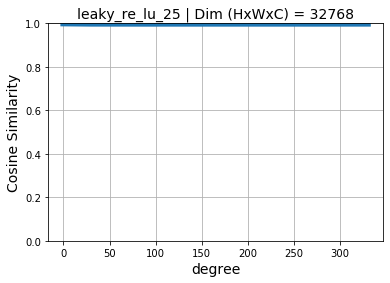

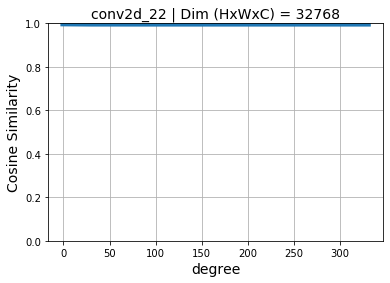

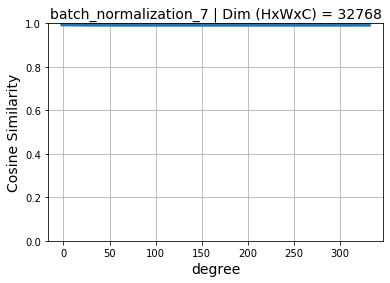

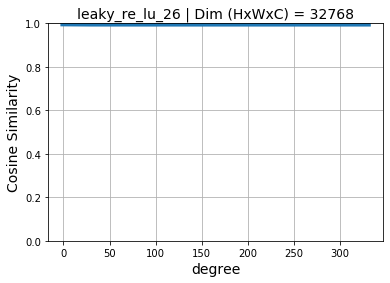

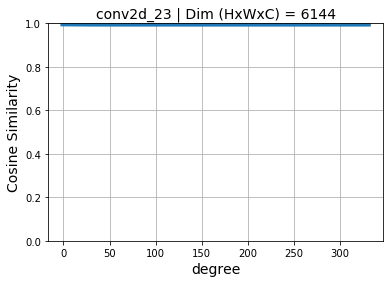

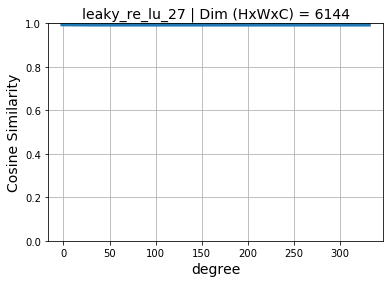

In [54]:
copy_size = 12
x = np.linspace(0,360,copy_size+1)[:-1]
for ikey in results.keys():
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, deg_mean_list[ikey], linewidth=6)
    _,h,w,c = decoder_results[ikey].shape
    plt.title(f"{ikey} | Dim (HxWxC) = {h*w*c}", fontsize=14)
    plt.xlabel('degree', fontsize=14)
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.ylim(0,1.)
    plt.grid(True)
    plt.show()
    plt.close()

## Memo:
Try `leaky_re_lu_23`? Since the layer shows almost rotate-invariant from the consine similarity perspective

-------------------------
- Encoder

In [68]:
# TODO: debug 99 --> 100 since we stored 100 files
encoder_deg_mean_list = {}
for ikey in encoder_cos_results.keys():
    encoder_deg_mean_list[ikey] =  comp_means(encoder_cos_results, ikey=ikey)

In [61]:
encoder_deg_mean_list.keys()

dict_keys(['conv2d', 'leaky_re_lu', 'conv2d_1', 'leaky_re_lu_1', 'conv2d_2', 'leaky_re_lu_2', 'conv2d_3', 'batch_normalization', 'leaky_re_lu_3', 'conv2d_4', 'leaky_re_lu_4', 'conv2d_5', 'leaky_re_lu_5', 'conv2d_6', 'batch_normalization_1', 'leaky_re_lu_6', 'conv2d_7', 'leaky_re_lu_7', 'conv2d_8', 'leaky_re_lu_8', 'conv2d_9', 'batch_normalization_2', 'leaky_re_lu_9', 'conv2d_10', 'leaky_re_lu_10', 'conv2d_11', 'leaky_re_lu_11', 'conv2d_12', 'batch_normalization_3', 'leaky_re_lu_12', 'conv2d_13', 'leaky_re_lu_13', 'conv2d_14', 'leaky_re_lu_14'])

In [64]:
len(encoder_results['conv2d'])

99

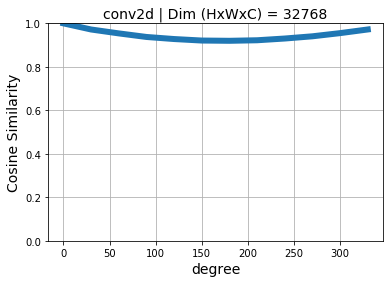

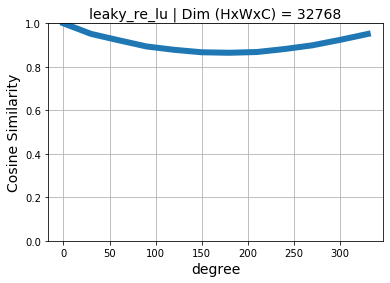

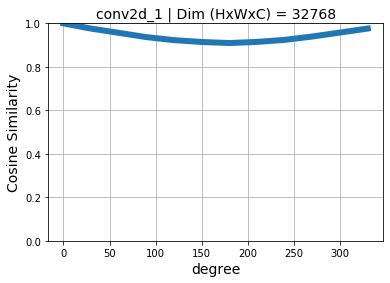

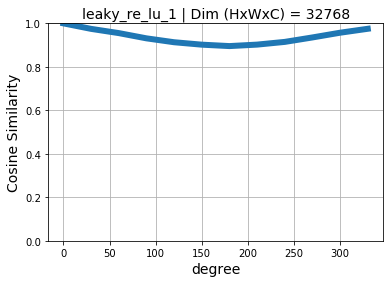

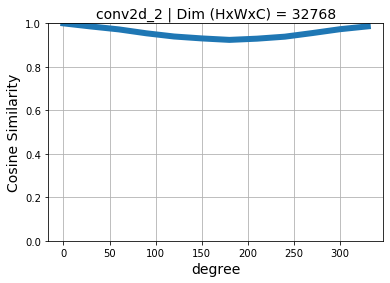

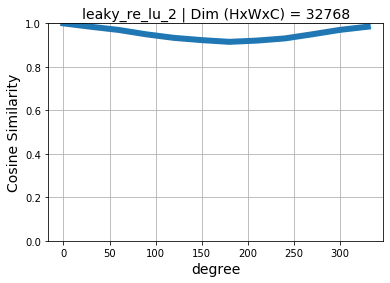

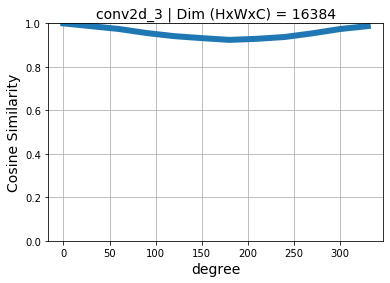

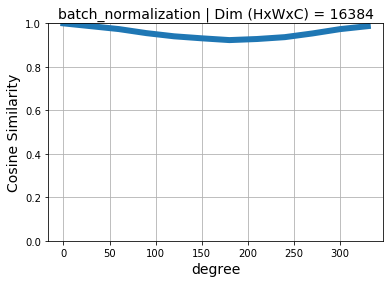

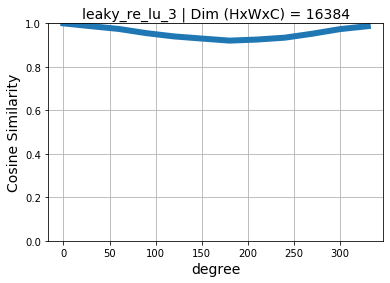

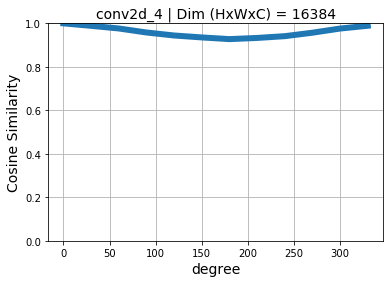

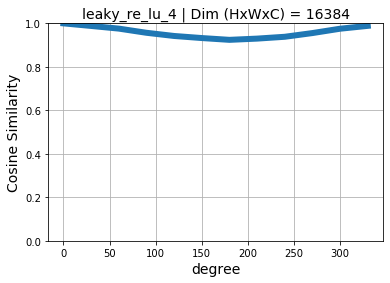

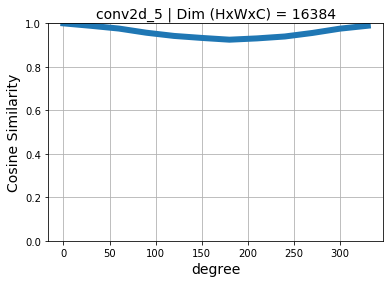

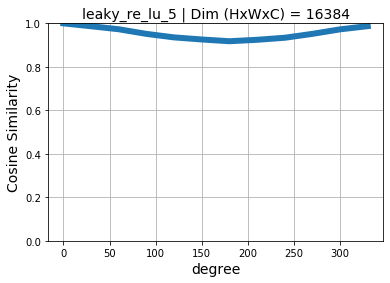

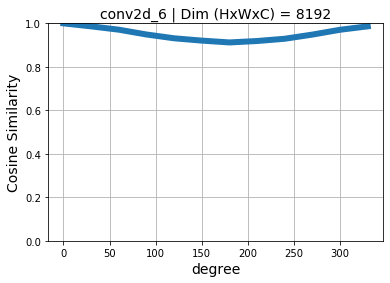

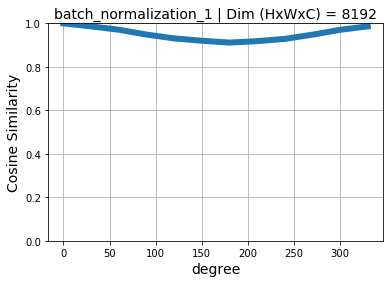

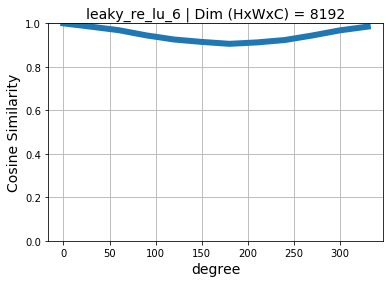

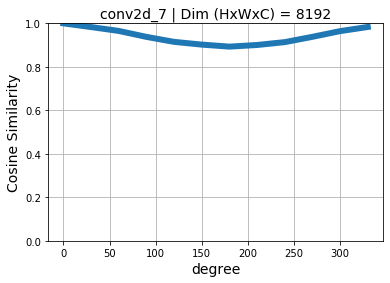

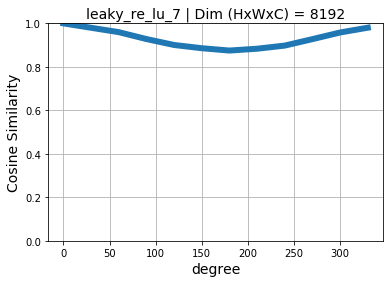

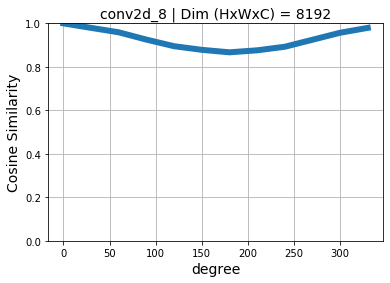

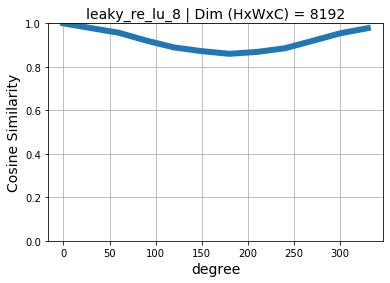

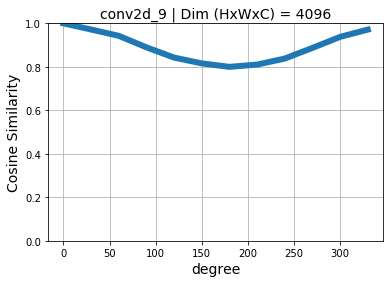

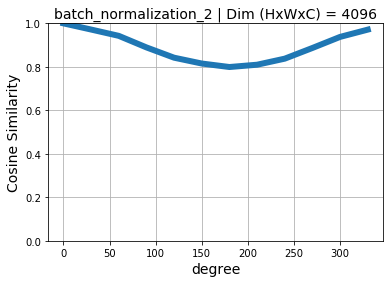

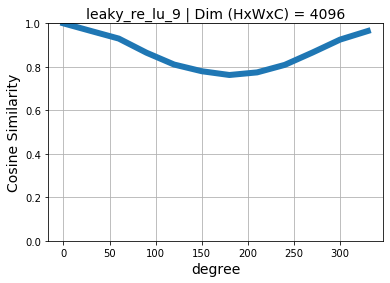

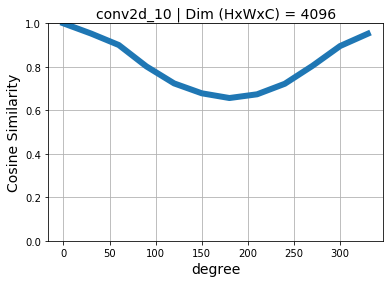

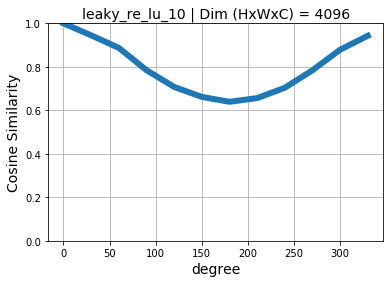

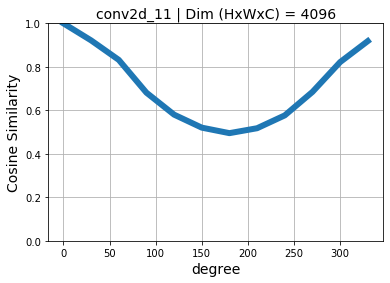

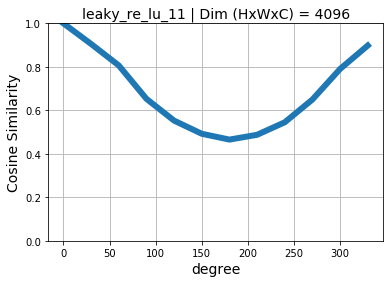

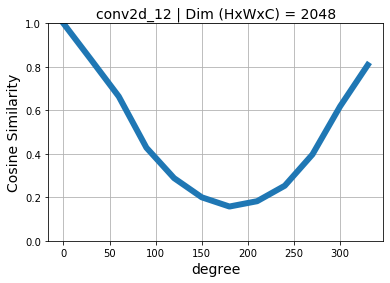

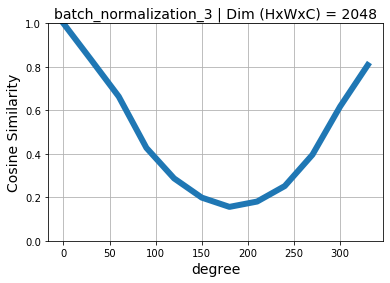

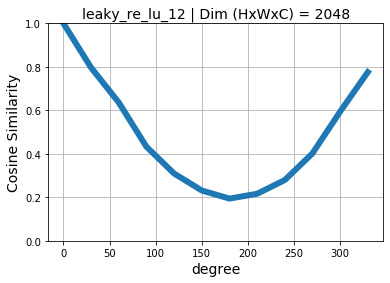

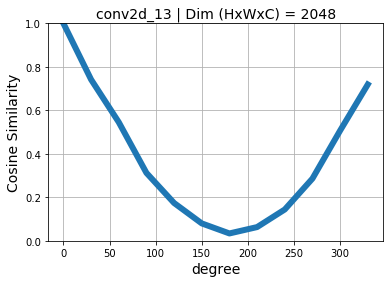

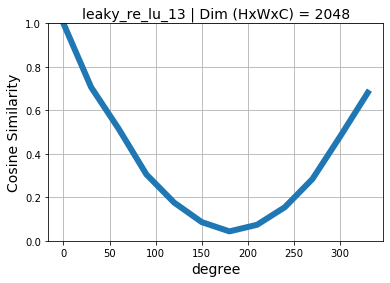

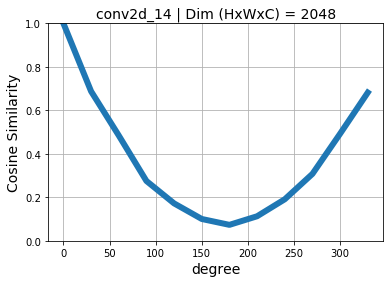

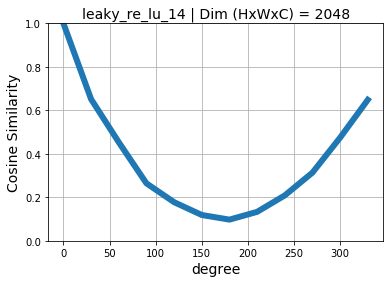

In [69]:
copy_size = 12
x = np.linspace(0,360,copy_size+1)[:-1]
for ikey in encoder_cos_results.keys():
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, encoder_deg_mean_list[ikey], linewidth=6)
    _,h,w,c = encoder_results[ikey].shape
    plt.title(f"{ikey} | Dim (HxWxC) = {h*w*c}", fontsize=14)
    plt.xlabel('degree', fontsize=14)
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.ylim(0,1.)
    plt.grid(True)
    plt.show()
    plt.close()